#### 一些轻量级的网络，如mobilenet中，会有深度可分离卷积depthwise separable convolution

#### 由depthwise(DW)和pointwise(PW)两个部分结合起来，用来提取特征feature map ,相比常规的卷积操作，其参数数量和运算成本比较低

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)

In [5]:
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(48000, 28, 28) (48000,)
(12000, 28, 28) (12000,)
(10000, 28, 28) (10000,)


In [6]:
from sklearn.preprocessing import StandardScaler
stand = StandardScaler()
x_train_scaler = stand.fit_transform(x_train.reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_valid_scaler = stand.transform(x_valid.reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_test_scaler = stand.transform(x_test.reshape(-1, 1)).reshape(-1, 28, 28, 1)

In [7]:
print(x_train_scaler.shape, y_train.shape)
print(x_test_scaler.shape, y_test.shape)

(48000, 28, 28, 1) (48000,)
(10000, 28, 28, 1) (10000,)


In [8]:
# Conv2D -> SeparableConv2D -> MaxPool2D
model = keras.models.Sequential()

# 一次
model.add(
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, activation='selu', padding="same", input_shape=[28, 28, 1]))
model.add(
    tf.keras.layers.SeparableConv2D(
        filters=32, kernel_size=3, activation='selu', padding="same"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2))

# 二次
model.add(
    tf.keras.layers.SeparableConv2D(
        filters=64, kernel_size=3, activation='selu', padding="same"))
model.add(
    tf.keras.layers.SeparableConv2D(
        filters=64, kernel_size=3, activation='selu', padding="same"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2))

# 三次
model.add(
    tf.keras.layers.SeparableConv2D(
        filters=128, kernel_size=3, activation='selu', padding="same"))
model.add(
    tf.keras.layers.SeparableConv2D(
        filters=128, kernel_size=3, activation='selu', padding="same"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation="selu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [9]:
# Depthwise Convolution的一个卷积核负责一个通道，一个通道只被一个卷积核卷积
#   卷积核的数量与上一层的通道数相同
#   卷积部分的参数个数:（filter size * 当前层filter数量(上一层的通道数相同)

# Pointwise Convolution的运算与常规卷积运算非常相似，它的卷积核的尺寸为 1×1×M，M为上一层的通道数
#   卷积部分的参数个数:1 * 1 * 上一层的通道数  * 当前层filter数量

In [10]:
model.summary()

# DW(9 * 32) + PW(32 * 32) + 偏置(32) = 1344
# DW(9 * 32) + PW(32 * 64) + 偏置(64) = 2400
# DW(9 * 64) + PW(64 * 64) + 偏置(64) = 4736

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
separable_conv2d (SeparableC (None, 28, 28, 32)        1344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 14, 14, 64)        2400      
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 14, 14, 64)        4736      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 7, 7, 128)         8

In [11]:
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]
model.compile(loss="sparse_categorical_crossentropy", optimizer= keras.optimizers.SGD(0.01), metrics = ["accuracy"])
history = model.fit(x_train_scaler, y_train, 
                    validation_data=(x_valid_scaler, y_valid), 
                    epochs=5, 
                    callbacks=callbacks)

Epoch 1/5
1500/1500 [==============================] - 160s 107ms/step - loss: 2.3026 - accuracy: 0.1040 - val_loss: 2.3007 - val_accuracy: 0.1076
Epoch 2/5
1500/1500 [==============================] - 154s 103ms/step - loss: 2.0283 - accuracy: 0.2728 - val_loss: 0.9756 - val_accuracy: 0.6590
Epoch 3/5
1500/1500 [==============================] - 154s 103ms/step - loss: 0.8212 - accuracy: 0.6956 - val_loss: 0.7505 - val_accuracy: 0.7236
Epoch 4/5
1500/1500 [==============================] - 152s 101ms/step - loss: 0.7005 - accuracy: 0.7390 - val_loss: 0.6502 - val_accuracy: 0.7473
Epoch 5/5
1500/1500 [==============================] - 157s 105ms/step - loss: 0.6358 - accuracy: 0.7645 - val_loss: 0.5968 - val_accuracy: 0.7751


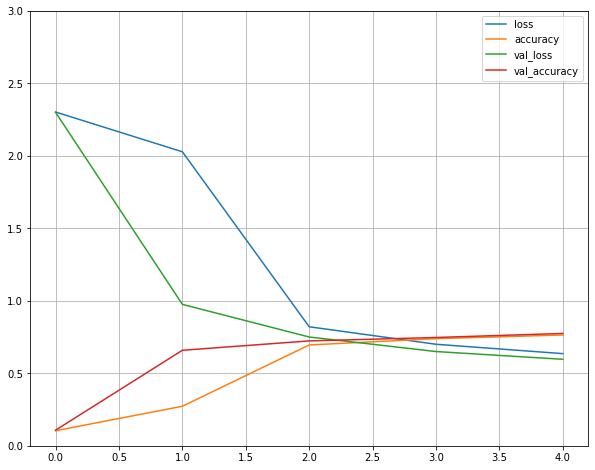

In [12]:
def plt_learning_curve(history):
    pd.DataFrame(history).plot(figsize=(10,8))
    plt.grid(True)
    plt.ylim(0, 3)
    plt.show()
    
plt_learning_curve(history.history)

In [13]:
model.evaluate(x_test_scaler, y_test)

313/313 [==============================] - 12s 37ms/step - loss: 0.6209 - accuracy: 0.7634


[0.6208548545837402, 0.7634000182151794]